# Preprocessing and EDA
---

### Objective
This notebook seeks to examine basic trends within the dataset and preprocess data in anticipation of the modeling process. Using matplotlib and seaborn, histograms, scatterplots, and correlation heatmaps will guide my decisions as to which features to focus on in my models as the best predictors of house sale price in Ames, Iowa.

---
#### External Libraries Import

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datapreprocessing import DataPreprocessing
import warnings
warnings.filterwarnings('ignore')

#### Read Cleaned Datasets

In [28]:
df_train = pd.read_csv('../datasets/clean_train.csv')
df_test = pd.read_csv('../datasets/clean_test.csv')

In [29]:
# retreive two dataframes separating categorical features from the numerical features
df_numeric = df_train.select_dtypes(exclude = ['object'])
df_object = df_train.select_dtypes(include = ['object'])

#### Plot Distribution of Each Numerical Feature

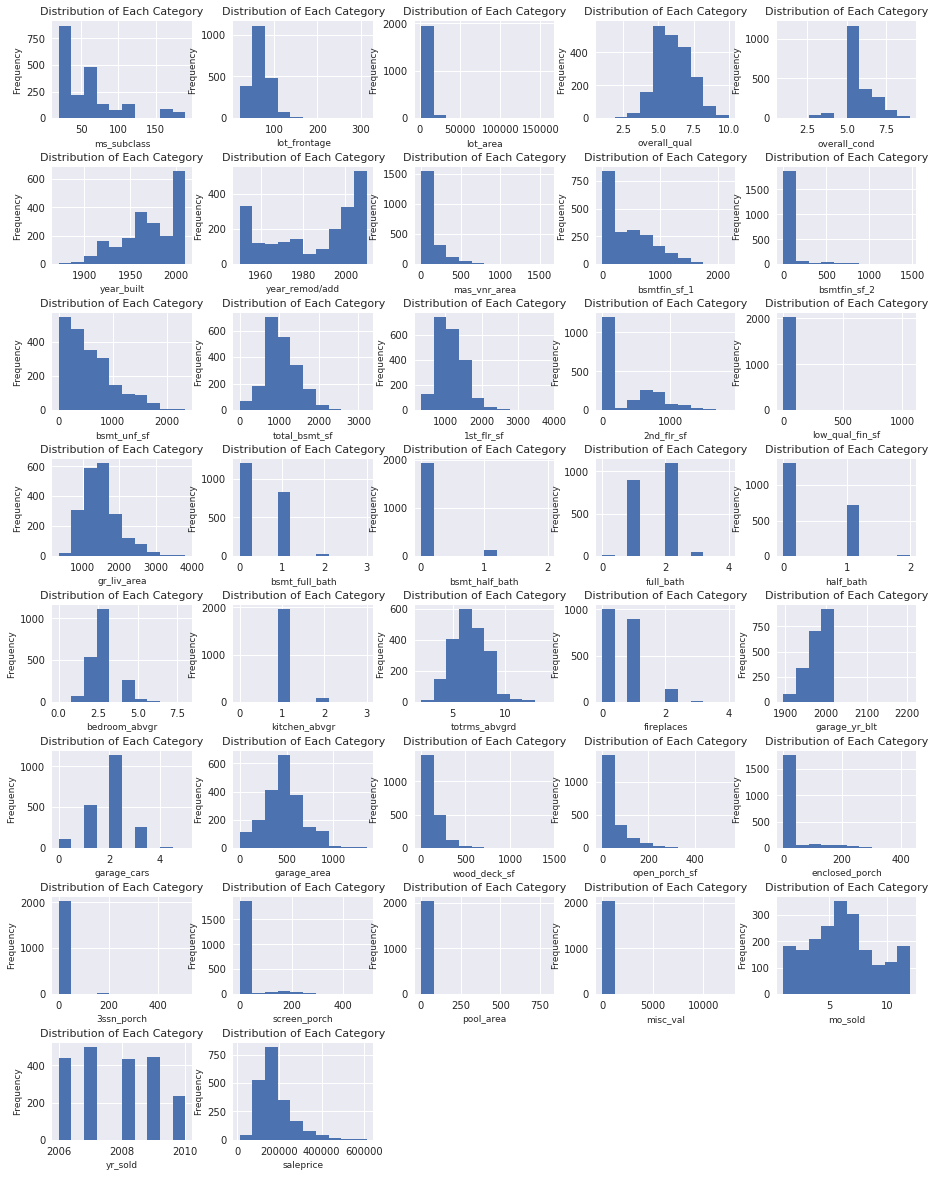

In [30]:
# without id and pid (irrelevant)
plt.figure(figsize = (12,100))
for i , col in enumerate(df_numeric.columns[2:]):
    plt.subplot(25 , 5 , (i+1))
    plt.subplots_adjust(left=1, bottom=.5, right=2, top=1, wspace=.3, hspace=.5)
    plt.hist(df_train[col])
    plt.title('Distribution of Each Category', fontsize = 11)
    plt.xlabel(col , fontsize = 9)
    plt.ylabel('Frequency', fontsize = 9)

This lengthy display of histograms facilitates a quick scan of evenly distributed numerical features. I can make assumptions on the strength of each feature based on their histograms. I expect the features with the most normal distributions to have the strongest predictive power for this dataset.
- Expected poor predictors:
    - kitchen_abvgr 
    - pool_area
    - misc_val
    - bsmtfin_sf_2
    - (porch features)
<br><br>
- Expected strong predictors:
    - total_bsmt_sf
    - overall_qual
    - gr_liv_area
    - totrms_abvgrd
    - garage_area

#### Numerically Rank Categorical Variables

In [23]:
# convert categorical data for train and test datasets
dp = DataPreprocessing()

dp.create_ordinal_data(df_train , df_test)

In [24]:
# very few null values still exist in test

dp.get_missing_values(df_test)

,features,num_missing_values
0,roof_matl,2
1,exterior_1st,1
2,exterior_2nd,2
3,mas_vnr_type,1
4,heating,1
5,electrical,1
6,kitchen_qual,1
7,sale_type,1


In [25]:
# fill the null values that still exist in test with random choices

dp.impute_missing_values(df_test , 'random')

#### Plot Distribution of Each Categorical Feature

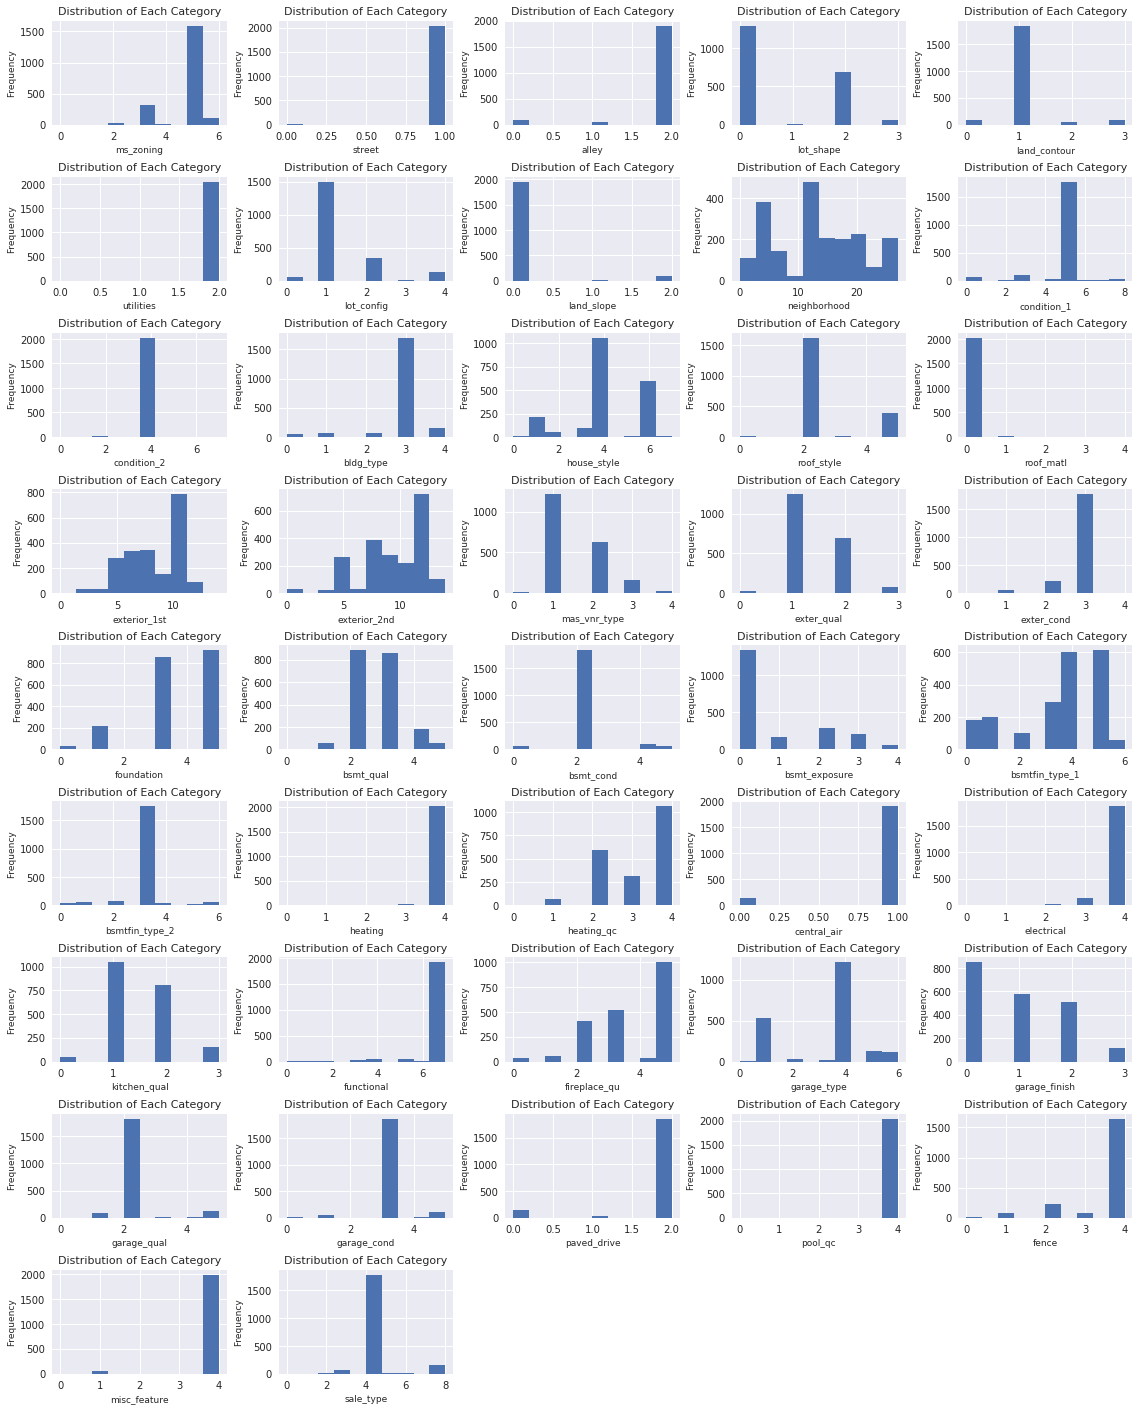

In [8]:
plt.figure(figsize = (15,120))
for i , col in enumerate(df_object.columns):
    plt.subplot(28 , 5 , (i+1))
    plt.subplots_adjust(left=1, bottom=.5, right=2, top=1, wspace=.3, hspace=.5)
    plt.hist(df_train[col] , bins = 10)
    plt.title('Distribution of Each Category', fontsize = 11)
    plt.xlabel(col , fontsize = 9)
    plt.ylabel('Frequency', fontsize = 9)

Features with single dominating categories will have little predictive power for this dataset. Many of these features fall into that. In this case, the strong predictors will an even distribution among categories.
- Expected poor predictors:
    - street
    - alley
    - utitilities
    - roof_matl
    - exter_cond
    - heating
<br><br>
- Expected strong predictors:
    - neighborhood
    - exter_qual
    - bsmt_qual
    - kitchen_qual
    - garage_finish
    


### Visualize Data

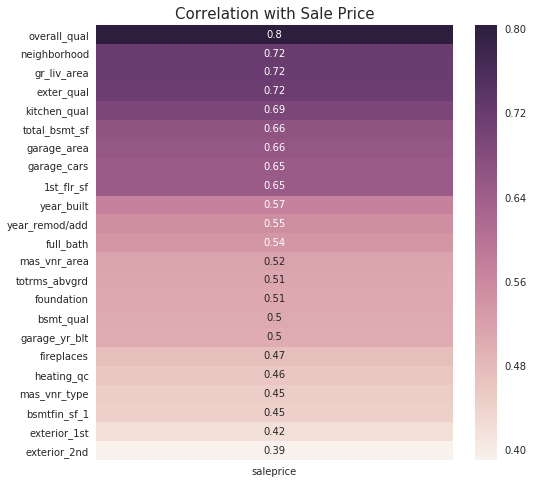

In [9]:
# create a correlation heatmap to find strong positive correlations

plt.figure(figsize=(8,8))
sns.heatmap(df_train.corr()[['saleprice']].sort_values('saleprice',ascending=False)[1:24],annot=True)
plt.title('Correlation with Sale Price' , fontsize = 15);

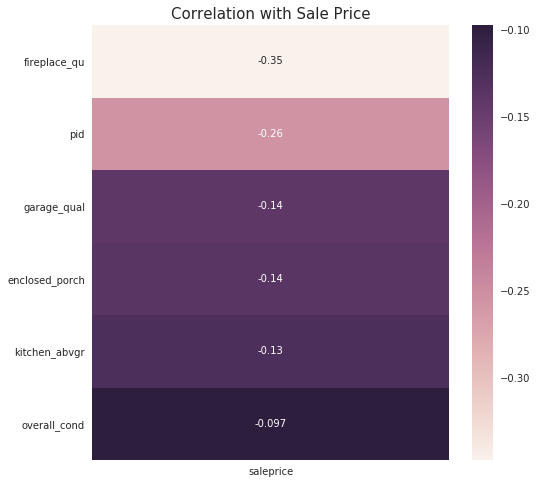

In [10]:
plt.figure(figsize=(8,8))
sns.heatmap(df_train.corr()[['saleprice']].sort_values('saleprice')[:6],annot=True)
plt.title('Correlation with Sale Price' , fontsize = 15);

- All features in between these heat maps have insignificant correlations with Sale Price 

#### Create a list of interesting features

In [11]:
# create a list of features with above 0.40 (absolute value) correlation coefficient with Sale Price

interesting_features = []
for col in df_train.columns:
    if abs(np.corrcoef(df_train['saleprice'], df_train[col])[0][1]) > 0.40:
        interesting_features.append(col)
        
# remove the dependent variable 'saleprice' from this list
interesting_features.remove('saleprice')

#### Create scatter plots for each interesting feature

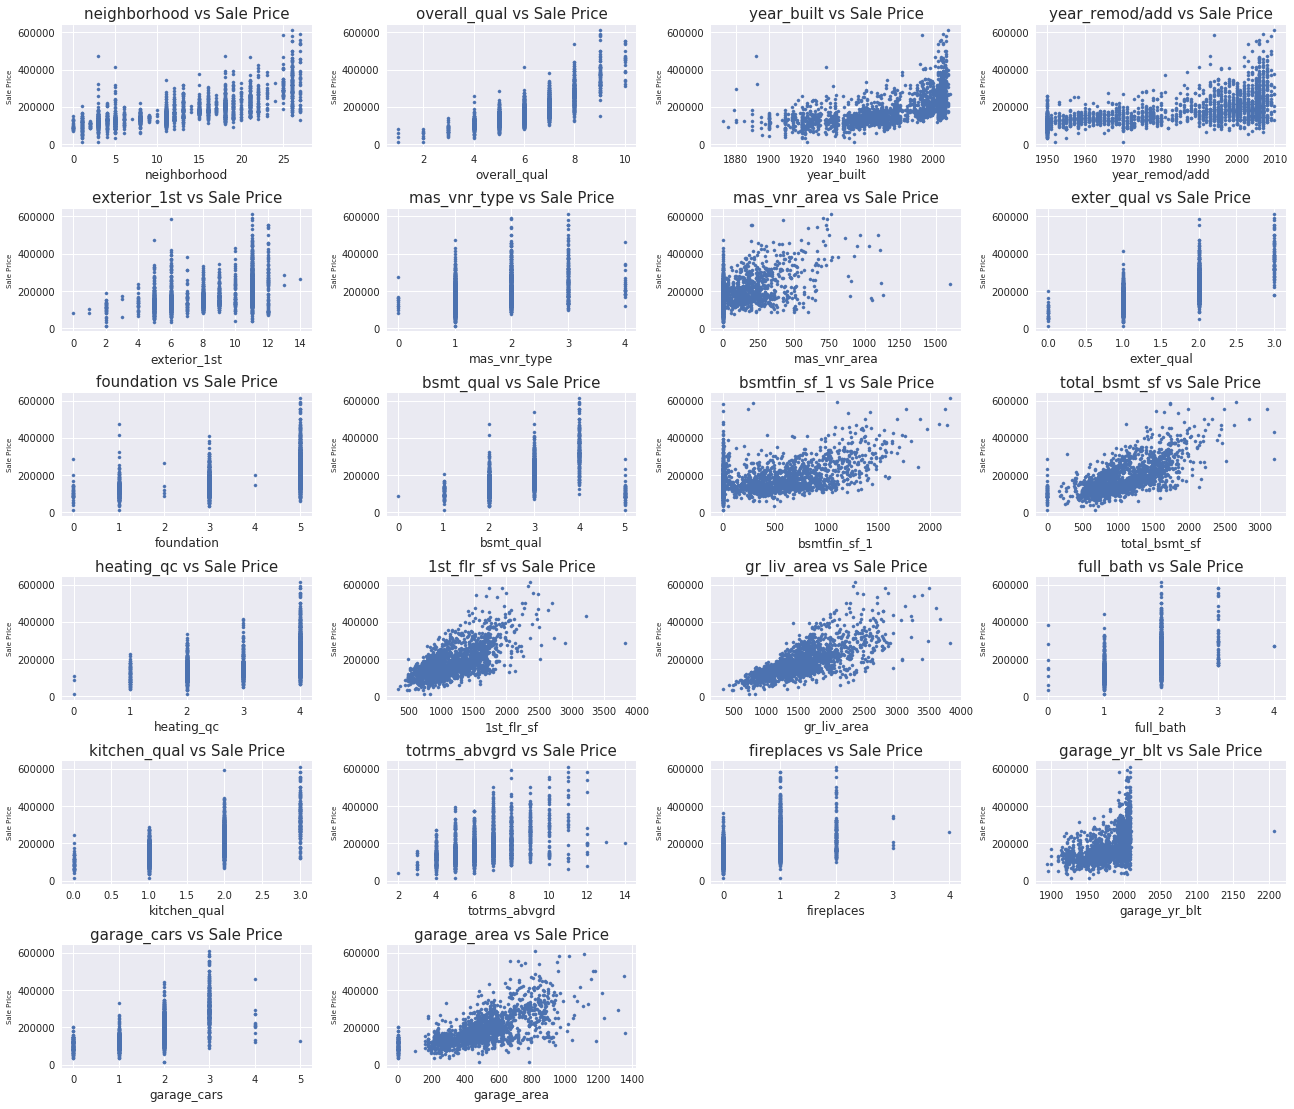

In [12]:
plt.figure(figsize = (17,75))
for i , col in enumerate(df_train[interesting_features]):
    plt.subplot(15 , 4 , (i+1))
    plt.subplots_adjust(left=1, bottom=.5, right=2, top=1, wspace=.3, hspace=.5)
    plt.scatter(df_train[col], df_train['saleprice'] , s = 10)
    plt.title(col +' vs Sale Price', fontsize = 15)
    plt.xlabel(col, fontsize = 12)
    plt.ylabel('Sale Price' , fontsize = 7)

This display of scatter plots facilitates an easy method of comparison to adjust the features in the interesting features list:
- 'year_built' and 'year_remod/add' show an expontential curve. 
- 'mas_vnr_area', 'bsmtfin_sf_1', and 'garage_yr_blt' show irregular plots.

#### Transform some of the variables

In [13]:
# square root year built and year remodeled based on scatter plot for train and test

df_train['year_built'] = np.sqrt(df_train['year_built']) 
df_train['year_remod'] = np.sqrt(df_train['year_remod/add']) 


df_test['year_built'] = np.sqrt(df_test['year_built']) 
df_test['year_remod'] = np.sqrt(df_test['year_remod/add']) 

In [14]:
# remove mass veneer area and garage year built because of unpredictable graphs

interesting_features.remove('mas_vnr_area')
interesting_features.remove('garage_yr_blt')
interesting_features.remove('bsmtfin_sf_1')

#### Check for multicollinearity

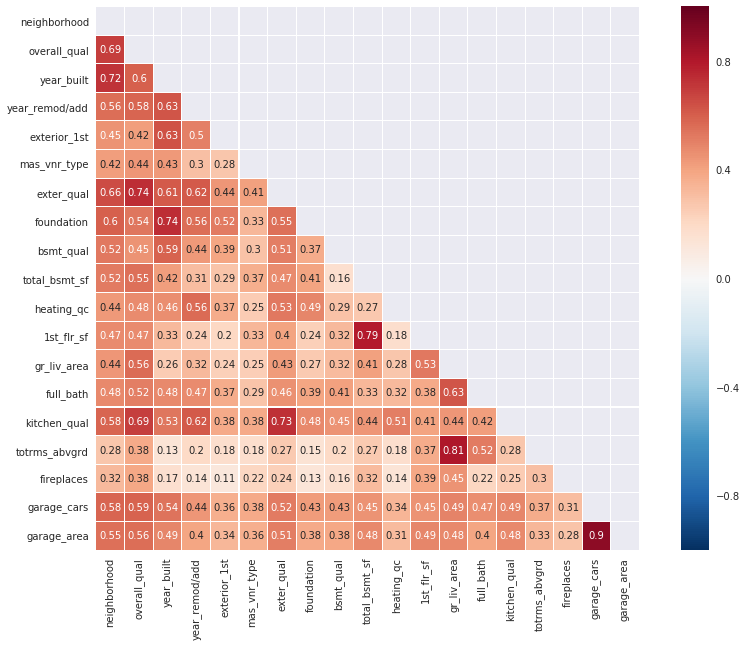

In [15]:
# create heatmap to identify multicollinearity

corr = df_train[interesting_features].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot = True, center=0,
            square=True, linewidths=.1);

In [16]:
# correct for multicollinearity by removing variables that correlate with others (above 0.75 correlation)
# I remove the variable that has a lower correlation with sale price

interesting_features.remove('garage_cars')
interesting_features.remove('totrms_abvgrd')
interesting_features.remove('1st_flr_sf')

### Final List of Features for Modeling

In [17]:
interesting_features

['neighborhood',
 'overall_qual',
 'year_built',
 'year_remod/add',
 'exterior_1st',
 'mas_vnr_type',
 'exter_qual',
 'foundation',
 'bsmt_qual',
 'total_bsmt_sf',
 'heating_qc',
 'gr_liv_area',
 'full_bath',
 'kitchen_qual',
 'fireplaces',
 'garage_area']

#### Save Final Data Sets

In [18]:
df_train.to_csv('../datasets/preprocessed_train.csv' , index = False) 
df_test.to_csv('../datasets/preprocessed_test.csv' , index = False)